In [9]:
## Make width of notebook 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
datasets_dir = 'datasets/'

## If running in google colab:
# from google.colab import drive
# drive.mount('/content/drive') # Needed to access drive files
# datasets_dir = 'drive/Shareddrives/CMPE-255-Term-Project/Dataset/'

In [29]:
def init_datasets():
    games_df = pd.read_csv(datasets_dir+'games.csv')
    winners_df = games_df['HOME_TEAM_WINS']
    games_details_df = pd.read_csv(datasets_dir+'games_details.csv')
    teams_df = pd.read_csv(datasets_dir+'teams.csv')
    players_df = pd.read_csv(datasets_dir+'players.csv')
    ranking_df = pd.read_csv(datasets_dir+'ranking.csv')
    # Clean up unnecessary columns
    del games_df['GAME_STATUS_TEXT']
    del ranking_df['LEAGUE_ID']
    del teams_df['LEAGUE_ID']
    del teams_df['YEARFOUNDED']
    del games_df['HOME_TEAM_WINS']

    return games_df, winners_df, games_details_df, teams_df, players_df, ranking_df

In [30]:
games_df, winners_df, games_details_df, teams_df, players_df, ranking_df = init_datasets()

# The Datasets

In [31]:
winners_df # Whether the home team won in a game in each row of `games_df`

0        1
1        1
2        0
3        0
4        0
        ..
23515    1
23516    0
23517    1
23518    1
23519    0
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [32]:
games_df

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
0,2020-12-19,12000047,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,0.425,23.0,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0
1,2020-12-19,12000048,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,0.295,24.0,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0
2,2020-12-19,12000049,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,0.396,21.0,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0
3,2020-12-18,12000039,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,0.262,19.0,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0
4,2020-12-18,12000040,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,0.356,27.0,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23515,2014-10-06,11400007,1610612737,1610612740,2014,1610612737,93.0,0.419,0.821,0.421,24.0,50.0,1610612740,87.0,0.366,0.643,0.375,17.0,43.0
23516,2014-10-06,11400004,1610612741,1610612764,2014,1610612741,81.0,0.338,0.719,0.381,18.0,40.0,1610612764,85.0,0.411,0.636,0.267,17.0,47.0
23517,2014-10-06,11400005,1610612747,1610612743,2014,1610612747,98.0,0.448,0.682,0.500,29.0,45.0,1610612743,95.0,0.387,0.659,0.500,19.0,43.0
23518,2014-10-05,11400002,1610612761,1610612758,2014,1610612761,99.0,0.440,0.771,0.333,21.0,30.0,1610612758,94.0,0.469,0.725,0.385,18.0,45.0


In [33]:
games_details_df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,12000047,1610612766,CHA,Charlotte,1628998,Cody Martin,F,NaN,17:06,0.0,...,0.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,-31.0
1,12000047,1610612766,CHA,Charlotte,1629023,P.J. Washington,F,NaN,24:58,4.0,...,1.0,6.0,7.0,2.0,2.0,1.0,5.0,3.0,9.0,-2.0
2,12000047,1610612766,CHA,Charlotte,203469,Cody Zeller,C,NaN,22:45,5.0,...,2.0,2.0,4.0,0.0,0.0,1.0,0.0,2.0,13.0,-23.0
3,12000047,1610612766,CHA,Charlotte,1628984,Devonte' Graham,G,NaN,31:30,8.0,...,1.0,3.0,4.0,3.0,2.0,0.0,4.0,0.0,25.0,-7.0
4,12000047,1610612766,CHA,Charlotte,1626179,Terry Rozier,G,NaN,26:48,8.0,...,1.0,4.0,5.0,6.0,1.0,0.0,0.0,2.0,24.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585789,11200005,1610612743,DEN,Denver,202706,Jordan Hamilton,NaN,NaN,19,4.0,...,0.0,2.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0,NaN
585790,11200005,1610612743,DEN,Denver,202702,Kenneth Faried,NaN,NaN,23,7.0,...,1.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,18.0,NaN
585791,11200005,1610612743,DEN,Denver,201585,Kosta Koufos,NaN,NaN,15,3.0,...,3.0,5.0,8.0,0.0,1.0,0.0,0.0,3.0,6.0,NaN
585792,11200005,1610612743,DEN,Denver,202389,Timofey Mozgov,NaN,NaN,19,1.0,...,1.0,2.0,3.0,1.0,0.0,0.0,4.0,2.0,2.0,NaN


In [108]:
teams_df

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends
5,0,1610612743,1976,2019,DEN,Nuggets,Denver,Pepsi Center,19099.0,Stan Kroenke,Tim Connelly,Michael Malone,No Affiliate
6,0,1610612745,1967,2019,HOU,Rockets,Houston,Toyota Center,18104.0,Tilman Fertitta,Daryl Morey,Mike D'Antoni,Rio Grande Valley Vipers
7,0,1610612746,1970,2019,LAC,Clippers,Los Angeles,Staples Center,19060.0,Steve Ballmer,Michael Winger,Doc Rivers,Agua Caliente Clippers of Ontario
8,0,1610612747,1948,2019,LAL,Lakers,Los Angeles,Staples Center,19060.0,Jerry Buss Family Trust,Rob Pelinka,Frank Vogel,South Bay Lakers
9,0,1610612748,1988,2019,MIA,Heat,Miami,AmericanAirlines Arena,19600.0,Micky Arison,Pat Riley,Erik Spoelstra,Sioux Falls Skyforce


In [22]:
ranking_df[ranking_df['RETURNTOPLAY'].notnull()]

,TEAM_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
4590,1610612749,22019,2020-12-10,East,Milwaukee,73,56,17,0.767,30-5,26-12,1.0
4591,1610612761,22019,2020-12-10,East,Toronto,72,53,19,0.736,26-10,27-9,1.0
4592,1610612738,22019,2020-12-10,East,Boston,72,48,24,0.667,26-10,22-14,1.0
4593,1610612754,22019,2020-12-10,East,Indiana,73,45,28,0.616,25-11,20-17,1.0
4594,1610612748,22019,2020-12-10,East,Miami,73,44,29,0.603,29-7,15-22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8695,1610612741,22019,2020-03-12,East,Chicago,65,22,43,0.338,14-20,8-23,0.0
8696,1610612752,22019,2020-03-12,East,New York,66,21,45,0.318,11-22,10-23,0.0
8697,1610612765,22019,2020-03-12,East,Detroit,66,20,46,0.303,11-22,9-24,0.0
8698,1610612737,22019,2020-03-12,East,Atlanta,67,20,47,0.299,14-20,6-27,0.0


In [66]:
players_df

,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
0,Royce O'Neale,1610612762,1626220,2019
1,Bojan Bogdanovic,1610612762,202711,2019
2,Rudy Gobert,1610612762,203497,2019
3,Donovan Mitchell,1610612762,1628378,2019
4,Mike Conley,1610612762,201144,2019
...,...,...,...,...
7223,Lanny Smith,1610612758,201831,2009
7224,Warren Carter,1610612752,201999,2009
7225,Bennet Davis,1610612751,201834,2009
7226,Brian Hamilton,1610612751,201646,2009


# Exploring the Data

## Quantifying home team advantage
Teams playing at home have the advantage over the visiting teams; The home team win rate overall is 59.1%.

In addition, home teams data shows greater means than the visiting teams in the following:
- 2.9 more points
- 1.1% more FGP
- 1.3 more rebounds
- 1.4 more assists

In [81]:
games_df['HOME_TEAM_WINS'].describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

In [95]:
def plot_diff(d1,d2,title,bins=30,alpha=0.6):
    d1.plot.hist(bins=bins, title=title, alpha=alpha)
    d2.plot.hist(bins=bins, alpha=alpha)
    plt.legend()
    plt.show()
    print('Difference:')
    print((d1-d2).describe())

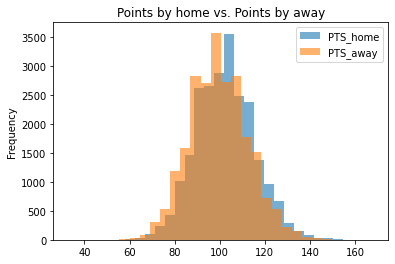

Difference:
count    23421.000000
mean         2.946843
std         13.289384
min        -58.000000
25%         -6.000000
50%          4.000000
75%         11.000000
max         61.000000
dtype: float64


In [96]:
plot_diff(games_df['PTS_home'], games_df['PTS_away'], 'Points by home vs. Points by away')

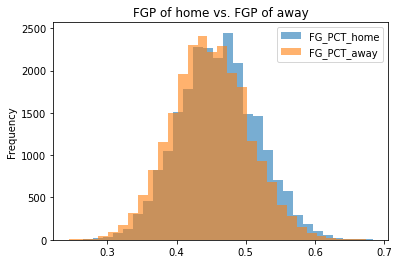

Difference:
count    23421.000000
mean         0.011578
std          0.077756
min         -0.307000
25%         -0.040000
50%          0.011000
75%          0.065000
max          0.319000
dtype: float64


In [84]:
plot_diff(games_df['FG_PCT_home'], games_df['FG_PCT_away'], 'FGP of home vs. FGP of away')

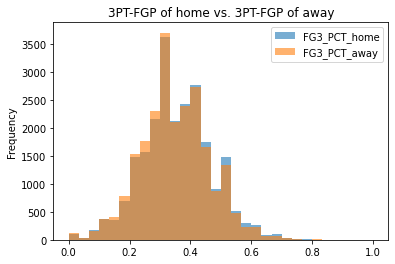

Difference:
count    23421.000000
mean         0.006705
std          0.160215
min         -0.800000
25%         -0.098000
50%          0.007000
75%          0.112000
max          0.700000
dtype: float64


In [85]:
plot_diff(games_df['FG3_PCT_home'], games_df['FG3_PCT_away'], '3PT-FGP of home vs. 3PT-FGP of away')

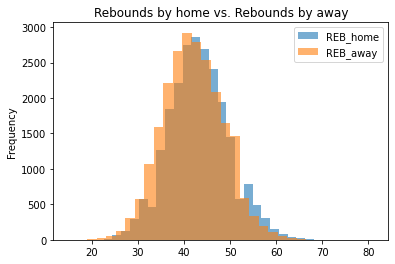

Difference:
count    23421.000000
mean         1.314504
std          8.945655
min        -39.000000
25%         -5.000000
50%          1.000000
75%          7.000000
max         38.000000
dtype: float64


In [86]:
plot_diff(games_df['REB_home'], games_df['REB_away'], 'Rebounds by home vs. Rebounds by away')

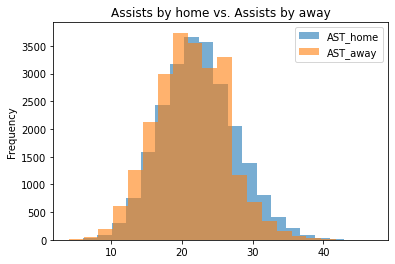

Difference:
count    23421.000000
mean         1.399385
std          6.748116
min        -24.000000
25%         -3.000000
50%          1.000000
75%          6.000000
max         26.000000
dtype: float64


In [90]:
plot_diff(games_df['AST_home'], games_df['AST_away'], 'Assists by home vs. Assists by away',bins=20)